<a href="https://colab.research.google.com/github/Trev621/GenAI/blob/main/HW7/Problem1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Author: Trevor Lacoste
The purpose of this assignment is to develop a music generation model using Transformers, specifically designed to generate new musical compositions in the style of Beethoven's Sonatas.

In [1]:
!apt-get install musescore
!apt-get install music21
!apt-get install fluidsynth

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  desktop-file-utils fonts-freefont-ttf libevdev2 libgudev-1.0-0 libinput-bin libinput10 libmd4c0
  libmtdev1 libportaudio2 libportmidi0 libqt5core5a libqt5dbus5 libqt5gui5 libqt5help5
  libqt5network5 libqt5printsupport5 libqt5qml5 libqt5qmlmodels5 libqt5qmlworkerscript5
  libqt5quick5 libqt5sql5 libqt5sql5-sqlite libqt5svg5 libqt5widgets5 libqt5xml5 libqt5xmlpatterns5
  libwacom-bin libwacom-common libwacom9 libxcb-icccm4 libxcb-image0 libxcb-keysyms1
  libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1 libxkbcommon-x11-0
  musescore-common musescore-general-soundfont-small qml-module-qt-labs-folderlistmodel
  qml-module-qt-labs-settings qml-module-qtgraphicaleffects qml-module-qtqml
  qml-module-qtqml-models2 qml-module-qtquick-controls qml-module-qtquick-dialogs
  qml-module-qtquick-layouts qml-module-qtquick

In [2]:
pip install music21

In [3]:
#Imports
import os
import glob
import numpy as np
import time
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, losses, callbacks

import music21

from transformer_utils import (
    parse_midi_files,
    load_parsed_files,
    get_midi_note,
    SinePositionEncoding,
)

## Parameters <a name="parameters"></a>

In [4]:
PARSE_MIDI_FILES = True
PARSED_DATA_PATH = "/content/"
DATASET_REPETITIONS = 1

SEQ_LEN = 50
EMBEDDING_DIM = 256
KEY_DIM = 256
N_HEADS = 5
DROPOUT_RATE = 0.3
FEED_FORWARD_DIM = 256
LOAD_MODEL = False

# optimization
EPOCHS = 5000
BATCH_SIZE = 256

GENERATE_LEN = 50

## 1. Prepare the Data

In [5]:
#Load the data
file_list = glob.glob("/content/*.mid")
print(f"Found {len(file_list)} midi files")

Found 16 midi files


In [6]:
parser = music21.converter

In [7]:
example_score = (
    music21.converter.parse(file_list[1]).splitAtQuarterLength(12)[0].chordify()
)

In [8]:
example_score.show("text")

{0.0} <music21.metadata.Metadata object at 0x7fc33d95b5b0>
{0.0} <music21.stream.Measure 1 offset=0.0>
    {0.0} <music21.instrument.Piano 'No Name: Piano'>
    {0.0} <music21.clef.TrebleClef>
    {0.0} <music21.tempo.MetronomeMark Quarter=100>
    {0.0} <music21.key.Key of C major>
    {0.0} <music21.meter.TimeSignature 4/4>
    {0.0} <music21.note.Rest dotted-half>
    {2.0} <music21.tempo.MetronomeMark molto allegro Quarter=145>
    {3.0} <music21.chord.Chord B-3 D4>
    {3.25} <music21.chord.Chord A3 D4>
    {3.5} <music21.chord.Chord B-3 D4>
    {3.75} <music21.chord.Chord F3 D4>
{4.0} <music21.stream.Measure 2 offset=4.0>
    {0.0} <music21.chord.Chord B-1 B-2 D4 F4>
    {0.5} <music21.note.Rest eighth>
    {1.0} <music21.chord.Chord B-1 B-2 B-3 D4>
    {1.5} <music21.note.Rest dotted-quarter>
    {2.75} <music21.tempo.MetronomeMark molto allegro Quarter=143>
    {3.0} <music21.tempo.MetronomeMark molto allegro Quarter=145>
    {3.0} <music21.chord.Chord B-3 D4>
    {3.25} <music

In [9]:
#Parse the MIDI files
if PARSE_MIDI_FILES:
    notes, durations = parse_midi_files(
        file_list, parser, SEQ_LEN + 1, PARSED_DATA_PATH
    )
else:
    notes, durations = load_parsed_files()

1 Parsing /content/Sonate05_Opus10_1.mid


<ipython-input-9-66293894b56b>:3: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  notes, durations = parse_midi_files(


5104 notes parsed
2 Parsing /content/Sonate11_Opus22.mid
12411 notes parsed
3 Parsing /content/Sonate04_Opus7.mid
21980 notes parsed
4 Parsing /content/Sonate14_Opus27_2_ClairDeLune.mid
27432 notes parsed
5 Parsing /content/Sonate06_Opus10_2.mid
32969 notes parsed
6 Parsing /content/Sonate07_Opus10_3.mid
39768 notes parsed
7 Parsing /content/Sonate01_Opus2_1.mid
46701 notes parsed
8 Parsing /content/Sonate03_Opus2_3.mid
56236 notes parsed
9 Parsing /content/Sonate16_Opus31_1.mid
66615 notes parsed
10 Parsing /content/Sonate13_Opus27_1.mid
71586 notes parsed
11 Parsing /content/Sonate09_Opus14_1.mid
75879 notes parsed
12 Parsing /content/Sonate10_Opus14_2.mid
80956 notes parsed
13 Parsing /content/Sonate02_Opus2_2.mid
88334 notes parsed
14 Parsing /content/Sonate15_Opus28_Pastorale.mid
95252 notes parsed
15 Parsing /content/Sonate12_Opus26.mid
100211 notes parsed
16 Parsing /content/Sonate08_Opus13_Pathetique.mid
106178 notes parsed
Building sequences of length 51


In [10]:
#Print example notes and durations
example_notes = notes[658]
example_durations = durations[658]
print("\nNotes string\n", example_notes, "...")
print("\nDuration string\n", example_durations, "...")


Notes string
 D4 D4 C4 rest rest G3 B3 D4 F4 D4 B3 B3 C4 C4 rest C4 G4 E-4 C5 G4 E-5 C5 G5 G5 rest G5 rest B3 G4 D4 B4 G4 D5 B4 G5 G5 rest G5 rest E-4 G4 E-4 C5 G4 E-5 C5 G5 E-5 D5 rest F6 ...

Duration string
 1/12 0.25 1.0 2.0 1.0 1/3 1/3 1/3 1/3 1/3 1/12 0.25 0.75 0.75 0.25 0.25 0.75 0.25 0.75 0.25 0.75 0.25 0.5 0.25 0.25 0.75 1.0 0.25 0.75 0.25 0.75 0.25 0.75 0.25 0.5 0.25 0.25 0.75 1.0 0.25 0.75 0.25 0.75 0.25 0.75 0.25 0.75 0.25 0.75 0.25 0.75 ...


## 2. Tokenize the data <a name="tokenize"></a>

In [11]:
#Tokenization
def create_dataset(elements):
    ds = (
        tf.data.Dataset.from_tensor_slices(elements)
        .batch(BATCH_SIZE, drop_remainder=True)
        .shuffle(1000)
    )
    vectorize_layer = layers.TextVectorization(
        standardize=None, output_mode="int"
    )
    vectorize_layer.adapt(ds)
    vocab = vectorize_layer.get_vocabulary()
    return ds, vectorize_layer, vocab


notes_seq_ds, notes_vectorize_layer, notes_vocab = create_dataset(notes)
durations_seq_ds, durations_vectorize_layer, durations_vocab = create_dataset(
    durations
)
seq_ds = tf.data.Dataset.zip((notes_seq_ds, durations_seq_ds))

In [12]:
#Display the same example notes and durations converted to ints
example_tokenised_notes = notes_vectorize_layer(example_notes)
example_tokenised_durations = durations_vectorize_layer(example_durations)
print("{:10} {:10}".format("note token", "duration token"))
for i, (note_int, duration_int) in enumerate(
    zip(
        example_tokenised_notes.numpy()[:11],
        example_tokenised_durations.numpy()[:11],
    )
):
    print(f"{note_int:10}{duration_int:10}")

note token duration token
        16         5
        16         2
        23         7
         2        10
         2         7
        28         4
        29         4
        16         4
        17         4
        16         4
        29         5


In [13]:
notes_vocab_size = len(notes_vocab)
durations_vocab_size = len(durations_vocab)

#Display some token:note mappings
print(f"\nNOTES_VOCAB: length = {len(notes_vocab)}")
for i, note in enumerate(notes_vocab[:10]):
    print(f"{i}: {note}")

print(f"\nDURATIONS_VOCAB: length = {len(durations_vocab)}")
#Display some token:duration mappings
for i, note in enumerate(durations_vocab[:10]):
    print(f"{i}: {note}")


NOTES_VOCAB: length = 80
0: 
1: [UNK]
2: rest
3: D5
4: G5
5: C5
6: E-5
7: G4
8: E5
9: F5

DURATIONS_VOCAB: length = 38
0: 
1: [UNK]
2: 0.25
3: 0.5
4: 1/3
5: 1/12
6: 1/6
7: 1.0
8: 0.75
9: 1.5


## Training Set

In [14]:
#Create the training set of sequences and the same sequences shifted by one note
def prepare_inputs(notes, durations):
    notes = tf.expand_dims(notes, -1)
    durations = tf.expand_dims(durations, -1)
    tokenized_notes = notes_vectorize_layer(notes)
    tokenized_durations = durations_vectorize_layer(durations)
    x = (tokenized_notes[:, :-1], tokenized_durations[:, :-1])
    y = (tokenized_notes[:, 1:], tokenized_durations[:, 1:])
    return x, y


ds = seq_ds.map(prepare_inputs).repeat(DATASET_REPETITIONS)

In [15]:
example_input_output = ds.take(1).get_single_element()
print(example_input_output)

((<tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[10,  8, 10, ..., 34, 34, 27],
       [ 8, 10, 15, ..., 34, 27, 27],
       [10, 15, 10, ..., 27, 27, 27],
       ...,
       [53, 20, 20, ...,  9,  8,  3],
       [20, 20, 20, ...,  8,  3,  2],
       [20, 20, 20, ...,  3,  2, 14]])>, <tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 3, ..., 2, 2, 2],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]])>), (<tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[ 8, 10, 15, ..., 34, 27, 27],
       [10, 15, 10, ..., 27, 27, 27],
       [15, 10, 11, ..., 27, 27, 27],
       ...,
       [20, 20, 20, ...,  8,  3,  2],
       [20, 20, 20, ...,  3,  2, 14],
       [20, 20, 53, ...,  2, 14, 14]])>, <tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[2, 2, 2, ..., 2, 2, 2],
       [2, 2, 3, ..., 2, 2, 2],
       [2, 3, 3, ..., 2, 2, 2],
       ...,

## Causal attention mask function

In [16]:
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
    )
    return tf.tile(mask, mult)


np.transpose(causal_attention_mask(1, 10, 10, dtype=tf.int32)[0])

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=int32)

## 3. Model Architecture

In [17]:
#Transformer block layer
class TransformerBlock(layers.Layer):
    def __init__(
        self,
        num_heads,
        key_dim,
        embed_dim,
        ff_dim,
        name,
        dropout_rate=DROPOUT_RATE,
    ):
        super(TransformerBlock, self).__init__(name=name)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.dropout_rate = dropout_rate
        self.attn = layers.MultiHeadAttention(
            num_heads, key_dim, output_shape=embed_dim
        )
        self.dropout_1 = layers.Dropout(self.dropout_rate)
        self.ln_1 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn_1 = layers.Dense(self.ff_dim, activation="relu")
        self.ffn_2 = layers.Dense(self.embed_dim)
        self.dropout_2 = layers.Dropout(self.dropout_rate)
        self.ln_2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = causal_attention_mask(
            batch_size, seq_len, seq_len, tf.bool
        )
        attention_output, attention_scores = self.attn(
            inputs,
            inputs,
            attention_mask=causal_mask,
            return_attention_scores=True,
        )
        attention_output = self.dropout_1(attention_output)
        out1 = self.ln_1(inputs + attention_output)
        ffn_1 = self.ffn_1(out1)
        ffn_2 = self.ffn_2(ffn_1)
        ffn_output = self.dropout_2(ffn_2)
        return (self.ln_2(out1 + ffn_output), attention_scores)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "key_dim": self.key_dim,
                "embed_dim": self.embed_dim,
                "num_heads": self.num_heads,
                "ff_dim": self.ff_dim,
                "dropout_rate": self.dropout_rate,
            }
        )
        return config

In [18]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.token_emb = layers.Embedding(
            input_dim=vocab_size,
            output_dim=embed_dim,
            embeddings_initializer="he_uniform",
        )
        self.pos_emb = SinePositionEncoding()

    def call(self, x):
        embedding = self.token_emb(x)
        positions = self.pos_emb(embedding)
        return embedding + positions

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config

In [19]:
#Building the transformer model
note_inputs = layers.Input(shape=(None,), dtype=tf.int32)
durations_inputs = layers.Input(shape=(None,), dtype=tf.int32)
note_embeddings = TokenAndPositionEmbedding(
    notes_vocab_size, EMBEDDING_DIM // 2
)(note_inputs)
duration_embeddings = TokenAndPositionEmbedding(
    durations_vocab_size, EMBEDDING_DIM // 2
)(durations_inputs)
embeddings = layers.Concatenate()([note_embeddings, duration_embeddings])
x, attention_scores = TransformerBlock(
    N_HEADS, KEY_DIM, EMBEDDING_DIM, FEED_FORWARD_DIM, name="attention"
)(embeddings)
note_outputs = layers.Dense(
    notes_vocab_size, activation="softmax", name="note_outputs"
)(x)
duration_outputs = layers.Dense(
    durations_vocab_size, activation="softmax", name="duration_outputs"
)(x)
model = models.Model(
    inputs=[note_inputs, durations_inputs],
    outputs=[note_outputs, duration_outputs],  #attention_scores
)
model.compile(
    "adam",
    loss=[
        losses.SparseCategoricalCrossentropy(),
        losses.SparseCategoricalCrossentropy(),
    ],
)
att_model = models.Model(
    inputs=[note_inputs, durations_inputs], outputs=attention_scores
)

In [20]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_and_position_embed… │ (None, None, 128)      │         10,240 │ input_layer[0][0]      │
│ (TokenAndPositionEmbeddi… │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_and_position_embed… │ (None, None, 128)      │          4,864 │ input_layer_1[0][0]    │
│ (TokenAndPositionEmbeddi… │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, None, 256)      │              0 │ token_and_position_em… │
│                           │                        │                │ token_and_position_em… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention                 │ [(None, None, 256),    │      1,447,424 │ concatenate[0][0]      │
│ (TransformerBlock)        │ (None, 5, None, None)] │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ note_outputs (Dense)      │ (None, None, 80)       │         20,560 │ attention[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ duration_outputs (Dense)  │ (None, None, 38)       │          9,766 │ attention[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,492,854 (5.69 MB)

 Trainable params: 1,492,854 (5.69 MB)

 Non-trainable params: 0 (0.00 B)

## 4. Training

In [21]:
# Create a MusicGenerator checkpoint
class MusicGenerator(callbacks.Callback):
    def __init__(self, index_to_note, index_to_duration, top_k=10):
        self.index_to_note = index_to_note
        self.note_to_index = {
            note: index for index, note in enumerate(index_to_note)
        }
        self.index_to_duration = index_to_duration
        self.duration_to_index = {
            duration: index for index, duration in enumerate(index_to_duration)
        }

    def sample_from(self, probs, temperature):
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs), probs

    def get_note(self, notes, durations, temperature):
        sample_note_idx = 1
        while sample_note_idx == 1:
            sample_note_idx, note_probs = self.sample_from(
                notes[0][-1], temperature
            )
            sample_note = self.index_to_note[sample_note_idx]

        sample_duration_idx = 1
        while sample_duration_idx == 1:
            sample_duration_idx, duration_probs = self.sample_from(
                durations[0][-1], temperature
            )
            sample_duration = self.index_to_duration[sample_duration_idx]

        new_note = get_midi_note(sample_note, sample_duration)

        return (
            new_note,
            sample_note_idx,
            sample_note,
            note_probs,
            sample_duration_idx,
            sample_duration,
            duration_probs,
        )

    def generate(self, start_notes, start_durations, max_tokens, temperature):
        attention_model = models.Model(
            inputs=self.model.input,
            outputs=self.model.get_layer("attention").output,
        )

        start_note_tokens = [self.note_to_index.get(x, 1) for x in start_notes]
        start_duration_tokens = [
            self.duration_to_index.get(x, 1) for x in start_durations
        ]
        sample_note = None
        sample_duration = None
        info = []
        midi_stream = music21.stream.Stream()

        midi_stream.append(music21.clef.BassClef())

        for sample_note, sample_duration in zip(start_notes, start_durations):
            new_note = get_midi_note(sample_note, sample_duration)
            if new_note is not None:
                midi_stream.append(new_note)

        while len(start_note_tokens) < max_tokens:
            x1 = np.array([start_note_tokens])
            x2 = np.array([start_duration_tokens])
            notes, durations = self.model.predict([x1, x2], verbose=0)

            repeat = True

            while repeat:
                (
                    new_note,
                    sample_note_idx,
                    sample_note,
                    note_probs,
                    sample_duration_idx,
                    sample_duration,
                    duration_probs,
                ) = self.get_note(notes, durations, temperature)

                if (
                    isinstance(new_note, music21.chord.Chord)
                    or isinstance(new_note, music21.note.Note)
                    or isinstance(new_note, music21.note.Rest)
                ) and sample_duration == "0.0":
                    repeat = True
                else:
                    repeat = False

            if new_note is not None:
                midi_stream.append(new_note)

            _, att = attention_model.predict([x1, x2], verbose=0)

            info.append(
                {
                    "prompt": [start_notes.copy(), start_durations.copy()],
                    "midi": midi_stream,
                    "chosen_note": (sample_note, sample_duration),
                    "note_probs": note_probs,
                    "duration_probs": duration_probs,
                    "atts": att[0, :, -1, :],
                }
            )
            start_note_tokens.append(sample_note_idx)
            start_duration_tokens.append(sample_duration_idx)
            start_notes.append(sample_note)
            start_durations.append(sample_duration)

            if sample_note == "START":
                break

        return info

    def on_epoch_end(self, epoch, logs=None):
        info = self.generate(
            ["START"], ["0.0"], max_tokens=GENERATE_LEN, temperature=0.5
        )
        midi_stream = info[-1]["midi"].chordify()
        print(info[-1]["prompt"])
        #midi_stream.show()
        midi_stream.write(
            "midi",
            fp=os.path.join(
                "/content/output",
                "output-" + str(epoch).zfill(4) + ".mid",
            ),
        )

In [22]:
#Tokenize starting prompt
music_generator = MusicGenerator(notes_vocab, durations_vocab)
music_generator._model = model

In [23]:
#Creating an output directory
output_dir = "/content/output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


In [24]:
#Training
model.fit(
    ds,
    epochs=100
)

Epoch 1/100
414/414 ━━━━━━━━━━━━━━━━━━━━ 35s 55ms/step - duration_outputs_loss: 1.2664 - loss: 4.8915 - note_outputs_loss: 3.6251
Epoch 2/100
414/414 ━━━━━━━━━━━━━━━━━━━━ 34s 56ms/step - duration_outputs_loss: 0.8256 - loss: 3.4752 - note_outputs_loss: 2.6495
Epoch 3/100
414/414 ━━━━━━━━━━━━━━━━━━━━ 24s 57ms/step - duration_outputs_loss: 0.7591 - loss: 3.2404 - note_outputs_loss: 2.4813
Epoch 4/100
414/414 ━━━━━━━━━━━━━━━━━━━━ 25s 59ms/step - duration_outputs_loss: 0.7391 - loss: 3.1808 - note_outputs_loss: 2.4417
Epoch 5/100
414/414 ━━━━━━━━━━━━━━━━━━━━ 26s 61ms/step - duration_outputs_loss: 0.7400 - loss: 3.1635 - note_outputs_loss: 2.4235
Epoch 6/100
414/414 ━━━━━━━━━━━━━━━━━━━━ 25s 59ms/step - duration_outputs_loss: 0.7287 - loss: 3.1134 - note_outputs_loss: 2.3847
Epoch 7/100
414/414 ━━━━━━━━━━━━━━━━━━━━ 25s 59ms/step - duration_outputs_loss: 0.7688 - loss: 3.1220 - note_outputs_loss: 2.3532
Epoch 8/100
414/414 ━━━━━━━━━━━━━━━━━━━━ 25s 60ms/step - duration_outputs_loss: 0.7544 - l

In [25]:
#Save the model in a directory
output_model_dir = "/content/model"
if not os.path.exists(output_model_dir):
    os.makedirs(output_model_dir)

model.save(os.path.join(output_model_dir, "model.keras"))

# 5. Music Generation

In [34]:
info = music_generator.generate(
    ["START"], ["0.0"], max_tokens=200, temperature=1.0
)
midi_stream = info[-1]["midi"].chordify()
#midi_stream.show()

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 5, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


In [35]:
#Creating a directory for the transformer output
output_dir = "/content/transformer_output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

## Write music to MIDI file

In [36]:
timestr = time.strftime("%Y%m%d-%H%M%S")
midi_stream.write(
    "midi",
    fp=os.path.join(
        "/content/transformer_output",
        "output-" + timestr + ".mid",
    ),
)

'/content/transformer_output/output-20241206-203528.mid'

## Note probabilities

In [37]:
max_pitch = 70
seq_len = len(info)
grid = np.zeros((max_pitch, seq_len), dtype=np.float32)

for j in range(seq_len):
    for i, prob in enumerate(info[j]["note_probs"]):
        try:
            pitch = music21.note.Note(notes_vocab[i]).pitch.midi
            grid[pitch, j] = prob
        except:
            pass  #Don't show key / time signatures

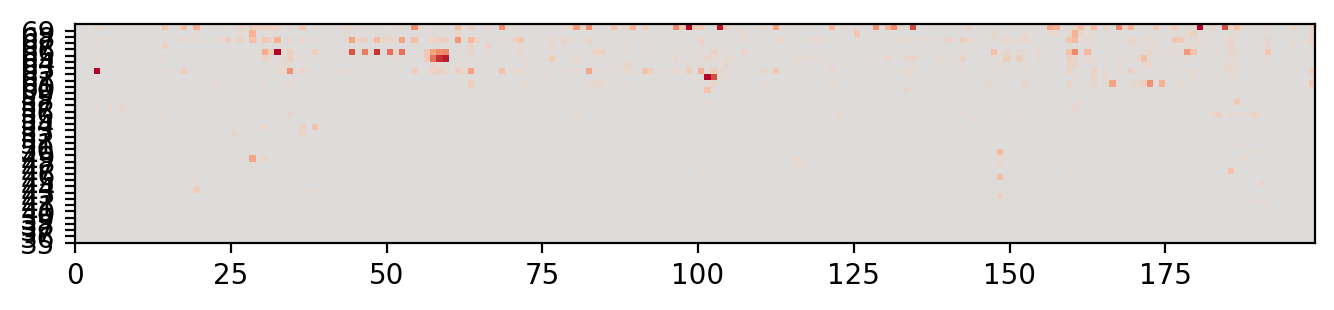

In [38]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_yticks([int(j) for j in range(35, 70)])
plt.imshow(
    grid[35:70, :],
    origin="lower",
    cmap="coolwarm",
    vmin=-0.5,
    vmax=0.5,
    extent=[0, seq_len, 35, 70],
)
plt.show()

## Saving to Google Drive

In [39]:
from google.colab import files
import shutil

shutil.make_archive("/content/model", 'zip', "my_folder")
shutil.make_archive("/content/output", 'zip', "my_folder")
shutil.make_archive("/content/transformer_output", 'zip', "my_folder")
shutil.make_archive("/content/data", 'zip', "my_folder")

'/content/data.zip'

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [40]:
# Saving the model and its data on the Google drive

!cp -r /content/data /content/drive/MyDrive/GenAI
!cp -r /content/model /content/drive/MyDrive/GenAI
!cp -r /content/output /content/drive/MyDrive/GenAI
!cp -r /content/transformer_output /content/drive/MyDrive/GenAI

cp: cannot stat '/content/data': No such file or directory
